# 大规模量子近似优化分治算法

<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## 概览

[量子近似优化算法](./QAOA_CN.ipynb)（quantum approximate optimization algorithm, QAOA）是一个将量子与经典结合起来，用于解决组合优化问题的算法。但是，由于现阶段量子比特数量的限制，该算法无法处理大规模问题，且该算法的运行时间随着问题规模的增大，成指数增长。关于量子近似优化算法更详细的讨论见 [1]。

分治法（divide-and-conquer, DC）是可以解决上述瓶颈的一种方法。主要是将一个大问题拆分若干个相似的子问题，将这些子问题解决之后再将子问题合并，从而得到母问题的解。Junde Li 等人在2021年提出量子近似优化的分治算法 [2] 将上述技术应用于解决较大规模的最大割问题。本教程所使用的方法在该论文的基础之上做出了一些改进。

## 具体算法

### 大图分割

在图论中，我们用一个图形的边 $E$ 和顶点 $V$ 定义一个图形 $G=(V,E)$。假设它有 $|V| = n$ 个顶点，但是含噪中型量子（noisy intermediate-scale quantum, NISQ）设备上最多可以运行 $k$ 个量子比特（$n > k$）。这种情况下，我们使用``大图分割 LGP``的方法将图形 $G$ 拆分两个子图 $G_0$ 和 $G_1$。为了防止遗漏任意一条边，在拆分的时候至少有一个点被两个子图共同拥有。我们把这些共有的顶点叫做分离顶点（集合），并且约束这个集合的大小小于 $k$。以下的代码定义了如何进行大图分割。

In [11]:
import networkx as nx # networkx的版本 >= 2.5
import matplotlib.pyplot as plt
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")

# 将一个图形分割成两个有重合的分离顶点子图
def NaiveLGP(g, k):
    E = list(g.edges)
    E = [(min([u, v]),max([u, v])) for (u, v) in E]
    E.sort(key=lambda tup:tup[0])
    V = list(g.nodes)
    V.sort()

    counter = 1
    while counter < k:
        num_nodes = counter
        nodes_combo = list(combinations(V, num_nodes))
        # 找有效的分离顶点
        for p in nodes_combo:
            V1 = [x for x in V if x not in p]
            E1 = [e for e in g.edges if e not in g.edges(p)]
            G1 = nx.Graph()
            G1.add_nodes_from(V1)
            G1.add_edges_from(E1)
            S = [G1.subgraph(c).copy() for c in nx.connected_components(G1)]
            if len(S) == 2:
                # 将分离顶点加入不相连的子图中
                V_S0 = list(S[0].nodes)
                E_S0 = list(S[0].edges)   
                V_S1 = list(S[1].nodes)
                E_S1 = list(S[1].edges)
                for (u, v) in g.edges(p):
                    if u in V_S0 or v in V_S0:
                        S[0].add_edges_from([(u, v)])
                    if u in V_S1 or v in V_S1:
                        S[1].add_edges_from([(u, v)])
                    if u in p and v in p:
                        S[0].add_edges_from([(u, v)])
                        S[1].add_edges_from([(u, v)])

                return S

        counter += 1
    print("G的连接度大于k")

    return {}

我们给了以下的例子去说明``大图分割``是如何进行的。假设一个随机图形有10个顶点，但是 NISQ 设备最多支持9个量子比特，即 $k=9$。那么根据``大图分割``，红色的顶点0和2将被选为分离顶点。首先将这些分离顶点去掉，剩下的图将是一个不连接图形并可以被分成两个子图，比如下图中的顶点3-9和顶点1。随后，我们再将这些分离顶点和相关边分别加回两个子图中，从而保证所有的边都不会被遗漏。

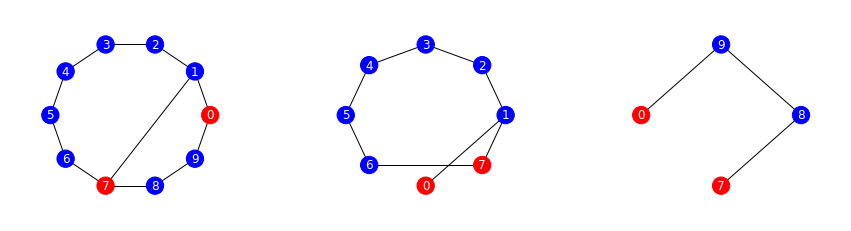

In [12]:
# 生成一个有 10 个顶点的图形
n = 10
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (1, 7),
                  (5, 6), (6, 7), (7, 8), (8, 9), (9, 0)])
    
k = 9 # 设定量子比特的最大数量
S = NaiveLGP(G,k) # 利用大图分割对图形 G 进行分割
sep_node = list(set(S[0].nodes).intersection(set(S[1].nodes))) # 找到分离顶点

# 图形示例
options = {
    "with_labels": True,
    "font_color": "white"
}
node_color1 = ["red" if i in sep_node else "blue" for i in range(n)]
node_color2 = ["red" if list(S[0].nodes)[i] in sep_node else "blue" for i in range(len(S[0].nodes))]
node_color3 = ["red" if list(S[1].nodes)[i] in sep_node else "blue" for i in range(len(S[1].nodes))]

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
for i, a in enumerate(ax):
    a.axis('off')
    a.margins(0.20)
nx.draw_networkx(G, pos=nx.circular_layout(G), ax=ax[0], **options, node_color=node_color1)
nx.draw_networkx(S[0], pos=nx.circular_layout(S[0]), ax=ax[1], **options, node_color=node_color2)
nx.draw_networkx(S[1], pos=nx.circular_layout(S[1]), ax=ax[2], **options, node_color=node_color3)


值得提醒的一点是，我们的例子中 $k=9$，``大图分割``得到的两个子图的顶点数都小于或等于 $k$，那么两个子图的最大割问题可以直接被``量子近似优化算法``解决。但如果得到的子图的顶点数依然大于 $k$，那我们将对子图重复之前的做法，直至所有的子图顶点都小于或等于 $k$。

### 图形重构

当``量子近似优化（分治）算法``被应用到分离的子图上之后，所有的顶点会被分成两个部分，即 $S_0$ 和 $S_1$。我们需要将子图的最大割进行整合，得到母图的最大割。因为两个子图有共同的顶点，即分离顶点，我们要确保它们所在的最大割集合吻合，即 $S_0$ 还是 $S_1$ 需要吻合。比如，如果对于一个子图来说，分离顶点在它的最大割当中所在的分割集合都是 $S_0$，而另一个子图的最大割中，分离顶点们在的分割集合是 $S_1$，那么相应的两个最大割将不能被整合。所以为了解决这一问题，对于每个子图，我们将提供多个可能的最大割，从而在这些可能的最大割当中寻找可以整合的且可能性最高的进行整合，从而得到母图的最大割。

In [13]:
def GR(str_cnt1, str_cnt2):
    com_cnt = []
    n = len(str_cnt1[0][0])
    com_index = []
    for i in range(n):
        if str_cnt1[0][0][i] != "x" and str_cnt2[0][0][i] != "x":
            com_index.append(i)

    for (str1, cnt1) in str_cnt1:
        for (str2, cnt2)  in str_cnt2:           
            # 检查分离顶点在两个子图所在的集合是否一致
            validity = [str1[i] == str2[i] for i in com_index]
            if False not in validity:
                com_str = [[0]] * n
                for i in range(n):
                    if str1[i] != "x":
                        com_str[i] = str(str1[i])
                    else:
                        com_str[i] = str(str2[i])
                com_cnt.append(("".join(com_str), min(cnt1, cnt2)))

    # 将{最大割：频率}按频率从大到小排列
    com_cnt.sort(key=lambda tup:tup[1])
    return com_cnt[::-1]

我们将延续上述10个顶点的圆的例子对``图形重构（graph reconstruction, GR）``进行说明。对于所分得的两个子图，我们先用``量子近似优化算法``求解最大割，再用``图形重构``将子图的最大割整合，得到原图的最大割。下面所给的代码实现了这一步骤。代码中的参数 $t$，代表想要保留最有可能的最大割的数量。如果 $t$ 大于 $2^n$，那么所有可能的最大割，即所有可能的顶点分类，都将被保留用于整合。

In [14]:
# 我们利用 量子近似优化算法 计算上面例子两个子图的最大割
# 在下一小章中，我们将使用 量子近似优化分治算法 计算子图的最大割，因为子图顶点数量有可能超过量子比特的限制。
import paddle
from paddle_quantum.QAOA.maxcut import find_cut

# 设定 量子近似优化算法 中的参数
p = 3     # 量子电路的层数
ITR = 100 # 训练迭代的次数
LR = 0.5  # 基于梯度下降的优化方法的学习率
# 设定 图形重构 中的参数
t = 10    # 想要保留最有可能的最大割的数量
paddle.seed(999)  # 固定随机种子

# 图形重构完整过程
S_str_cnt = []
for si in S:
    siv = list(si.nodes)
     
    # 计算子图的最大割
    tmp, si_str_cnt_relabeled = find_cut(si, p, ITR, LR)
    
    # 填充子图的最大割结果，使它们和原图的顶点数量和顺序吻合
    si_str_cnt = []
    for str_relabeled in si_str_cnt_relabeled:
        strr = ""
        for i in range(len(G.nodes)):
            if i in siv:
                strr += str_relabeled[siv.index(i)]
            else:
                strr += "x"
        si_str_cnt.append((strr, si_str_cnt_relabeled[str_relabeled]))
    si_str_cnt.sort(key=lambda tup:tup[1])
    S_str_cnt.append(si_str_cnt[::-1][:t])

# 当子图的最大割被找到之后，我们开始图形重构这一步
print("第一个子图的最大割：\n" + str(dict(S_str_cnt[0])))
print("第二个子图的最大割：\n" + str(dict(S_str_cnt[1])))
out_cnt = GR(S_str_cnt[0], S_str_cnt[1])
print("母图的最大割：\n" + str(dict(out_cnt[:t])))

第一个子图的最大割：
{'01101010xx': 0.07865697145462036, '10010101xx': 0.07865697145462036, '01010101xx': 0.07865694910287857, '10101010xx': 0.07865694910287857, '01010010xx': 0.04094246029853821, '10101101xx': 0.04094246029853821, '01011010xx': 0.04005919396877289, '01010110xx': 0.04005919396877289, '10101001xx': 0.04005919396877289, '10100101xx': 0.04005919396877289}
第二个子图的最大割：
{'1xxxxxx010': 0.4556591808795929, '0xxxxxx101': 0.4556591808795929, '0xxxxxx011': 0.025223204866051674, '1xxxxxx100': 0.025223204866051674, '0xxxxxx110': 0.010825536213815212, '1xxxxxx001': 0.010825536213815212, '0xxxxxx111': 0.002283714711666107, '1xxxxxx000': 0.002283714711666107, '1xxxxxx011': 0.00228371424600482, '0xxxxxx100': 0.00228371424600482}
母图的最大割：
{'1010101010': 0.07865694910287857, '0101010101': 0.07865694910287857, '1010010100': 0.025223204866051674, '1010100100': 0.025223204866051674, '0101011011': 0.025223204866051674, '0101101011': 0.025223204866051674, '1010110100': 0.025223204866051674, '0101001011':

就以上例子来说，对于第一个子图而言，最有可能的几个最大割将包括 {'01010101xx', '10010101xx', '01101010xx', '10101010xx'}，而第二个子图最有可能的最大割将包括 {'0xxxxxx101,'1xxxxxx010'}。这些字符串中的 'x' 代表不在这个子图却在母图的顶点。

从这个例子中我们看到，分离顶点 0 和 7 在第一个子图中可能的最大割，'01010101xx' 中分别属于 $S_0$ 和 $S_1$，它们在第二个子图的最大割，'0xxxxxx101'，中也分别属于 $S_0$ 和 $S_1$，所以我们可以整合这两个最大割并得到母图的最大割，'0101010101'，如下图第三张图所示。

以下为图形展示，前两个图为两个子图的最大割实例，最右的图为母图的最大割。红色点和蓝色点分别表示被分在在 $S_0$ 和 $S_1$ 中的顶点，虚线表示被切割的边。

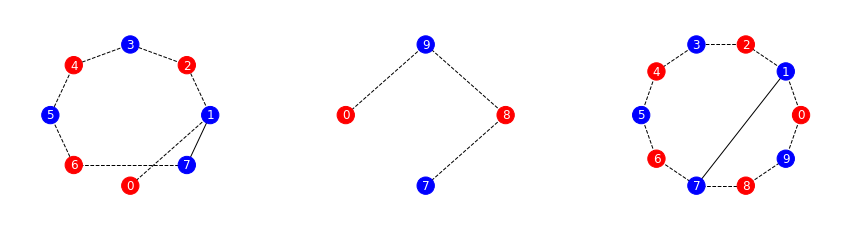

In [15]:
# 计算出的两个子图的最大割
strr1 =  '01010101xx'
strr2 = '0xxxxxx101' 
strr = '0101010101'

# 图形示例展示
options0 = {
    "node_color": ["red" if strr1[i] == '0' else "blue" for i in S[0].nodes],
    "style": ["solid" if strr1[u] == strr1[v] else "dashed" for (u, v) in list(S[0].edges)]
}
options1 = {
    "node_color": ["red" if strr2[i] == '0' else "blue" for i in S[1].nodes],
    "style": ["solid" if strr2[u] == strr2[v] else "dashed" for (u, v) in list(S[1].edges)]
}
options2 = {
    "node_color": ["red" if strr[i] == '0' else "blue" for i in range(n)],
    "style": ["solid" if strr[u] == strr[v] else "dashed" for (u, v) in list(G.edges)]
}

fig, ax = plt.subplots(1, 3, figsize=(15,4))
for i, a in enumerate(ax):
    a.axis('off')
    a.margins(0.20)
nx.draw_networkx(S[0], pos=nx.circular_layout(S[0]), ax=ax[0], **options, **options0)
nx.draw_networkx(S[1], pos=nx.circular_layout(S[1]), ax=ax[1], **options, **options1)
nx.draw_networkx(G, pos=nx.circular_layout(G), ax=ax[2], **options, **options2)

### 量子近似优化分治法

为了找到一个大图 $G$ 的最大割，我们采用``量子近似优化分治法``。这个方法像上面描述的一样，先递归性地利用``大图分割``分割图形，再利用``图形重构``递归性地整合两个子图的最大割。

首先如果输入图形的顶点数大于量子比特数量限制 $k$，它将被``大图分割``分成两个子图。反之，可以直接求解它的最大割（不用拆分）。每一个子图将递归性地被输入进``量子近似优化分治法``，直到它的最大割被返回。最大割被返回说明在某一步，它某些递归的子图的顶点数量小于$k$，直接被``量子近似优化分治法``解得，再一层一层地经历``图形重构``，直到返回这个子图所在层。

下面是利用``图形重构``和``大图分割``完成的``量子近似优化分治法``的代码。``量子近似优化分治法``将返回最有可能的最大割和前 $t$ 个最有可能的最大割。

In [16]:
def DC_QAOA(g, p, t, s, k, ITR, LR):
    if len(g.nodes) > k:
        # 利用 大图分割 得到两个子图
        S = NaiveLGP(g, k)

        S_str_cnt = []
        for si in S:
            siv = list(si.nodes)
            # 递归性地计算子图的最大割
            _, si_str_cnt_relabeled = DC_QAOA(si, p, t, s, k, ITR, LR)
            # 填充子图的最大割结果，使其和母图的顶点吻合
            si_str_cnt = []
            for str_relabeled in si_str_cnt_relabeled:
                strr = ""
                for v in g.nodes:
                    if v in siv:
                        strr += str_relabeled[siv.index(v)]
                    else:
                        strr += "x"     
                si_str_cnt.append((strr, si_str_cnt_relabeled[str_relabeled]))
            si_str_cnt.sort(key = lambda tup:tup[1])
            S_str_cnt.append(si_str_cnt[::-1][:t])

        # 利用 图形重构 整合子图最大割
        out_cnt = GR(S_str_cnt[0], S_str_cnt[1])
    else:
        if len(g.nodes) == 1:
            return [("0", 99999), ("1", 99999)]
        _, out_cnt = find_cut(g, p, ITR, LR, shots=3000)
        # 将词典格式转成列表格式，易于排序
        out_cnt = [(k, v) for k, v in out_cnt.items()]
        # 将{最大割：频率}按频率从大到小排列
        out_cnt.sort(key=lambda tup:tup[1])
        out_cnt = out_cnt[::-1]

    # 只保留最有可能的t个最大割
    out_cnt = out_cnt[:t]
    # 等比例调节频率的显示
    cnt_sum = sum(cnt for (str,cnt) in out_cnt)
    out_cnt = [(k, int(s * v / cnt_sum)) for (k, v) in out_cnt]

    return out_cnt[0][0], dict(out_cnt)

# 设定 量子近似优化算法 中的参数
p = 2     # 量子电路的层数
ITR = 100 # 训练迭代的次数
LR = 0.5  # 基于梯度下降的优化方法的学习率

# 设定 量子近似优化分治算法 中的参数
s = 3000  # 等比例调节频率的比例
t = 10    # 想要保留最有可能的最大割的数量
k = 5     # 量子比特的数量限制

# 量子近似优化分治算法使用
max_cut, out_cnt = DC_QAOA(G, p, t, s, k, ITR, LR)
print("最有可能的 t 个图形 G 的最大割: " + str(out_cnt))
print("量子近似优化分治算法找到的图形 G 的（最有可能的）最大割: " + str(max_cut))

最有可能的 t 个图形 G 的最大割: {'1010100100': 413, '1010101100': 405, '0101010011': 390, '0101011011': 379, '0100101011': 255, '1001010100': 253, '1011010100': 245, '0110101011': 230, '1010110100': 214, '0101010101': 212}
量子近似优化分治算法找到的图形 G 的（最有可能的）最大割: 1010100100


## 应用范围

**以上表述的``量子近似优化分治法``可以估计一个图形的最大割，当且仅当，它和它递归出来的顶点数量大于 $k$，且子图的伪连接度（pseudo-connectivity）都小于 $k$**。伪连接度的定义为：一个连接图变成不连接的两个子图所需要移除的最小的顶点数量。

当 $k > 1$ 的时候，圆圈就是一个例子。因为只需要移除两个点，圆圈就会被拆成两条不相连的子图，所以所有圆圈的伪连接度都是2。我们拿六个顶点的圆 $C_6$ 并且 $k=4$ 举例。``大图分割``会将它分成 $P_5$（顶点数量为5的子图）和 $P_2$，$P_2$ 的顶点数量在 $k$ 之下，可以直接使用``近似优化算法``计算。而子图 $P_5$ 是一个链状结构，他的伪连接度是 $1 < k$。所以``大图分割``将继续分割 $P_5$，并把它分成了 $P'_4$ 和 $P'_2$。新的子图的顶点数量都小于或等于 $k$，我们都不再需要考虑他们伪连接度。

``量子近似优化分治法``不可解的图包括顶点数量大于 $k$ 的完全图（complete graph）。对于完全图来说，无论怎么移除顶点，剩余的图都是连接图。有些图是否适用决定于 $k$ 的大小，我们以下给了个这样的例子。

最左的图就是实例图，这个图的伪连接度是2。如果 $k=2$，那么分离点的数量只能为1个，如果分离点是4,那么这个图被拆分成三部分而不是两部分（下图中间所示）；如果分离点是其他的几个，这个图仍然连在一起，没有被拆开。此外，该图的伪连接度为2并不小于 $k$，不满足条件，所以``量子近似优化分治法``并不适用于这个例子。但如果 $k=3$，伪连接度是 $2 < k$，这个图可以进行拆分成两个子图，其中一个的顶点数量小于等于 $k$，另一个的伪连接度显而易见是 $1<k$（移除顶点4）。``量子近似优化分治法``在这种情况下可以解决这个图。于是我们移除顶点0和4（如下图最右所示），剩下的图将是两个不相连的子图。我们再将分离顶点0和4加回去，并在这两个子图上计算最大割。``量子近似优化分治法``最终可以成功给出最大割。

![limitations-connectivity](./figures/dcqaoa-fig-applicability_example.png)

读者可以在以下代码中自己调试 $k$，利用``量子近似优化分治法``试验上述的示例图的最大割，从而感受这个方法的适用范围。

In [17]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 4), (1, 2), (1, 4), (2, 4), (3, 4)])
k = 3
_, out_cnt = DC_QAOA(G, p, t, s, k, ITR, LR)
print("最有可能的 t 个图形 G 的最大割：" + str(dict(out_cnt)))

最有可能的 t 个图形 G 的最大割：{'00101': 532, '11010': 511, '10110': 508, '00001': 490, '01001': 480, '11110': 479, '11111': 0, '11101': 0, '11011': 0, '11001': 0}


## 算法测试效果

下面，我们比较量子近似优化分治法所得到的最大割和半正定规划（SDP）方法得到的理论上界进行比较。这里，我们用的例子是10个顶点的随机图，量子比特数量限制 $k=5$。

为了能正确运行以下测试代码，用户首先应该安装 cvxpy：`pip install cvxpy`。**Windows 如果直接使用 pip 安装，在运行时可能会出现报错，建议新建 conda 环境后使用 conda 安装 cvxpy。** 更多详情请参考 [https://www.cvxpy.org/install/](https://www.cvxpy.org/install/)。

In [18]:
import cvxpy as cvx
import networkx as nx

def sdp_solver(G):
    """
    通过半正定规划 SDP 来找到最大割问题的理论上界。
    """
    n = len(G)
    adj_mat = nx.adjacency_matrix(G).toarray()
    Y = cvx.Variable((n, n), PSD=True)
    cut_size = 0.25 * cvx.sum(cvx.multiply(adj_mat, 1 - Y))
    problem = cvx.Problem(cvx.Maximize(cut_size), [cvx.diag(Y) == 1])
    opt_val = problem.solve(cvx.SCS)

    return opt_val

In [19]:
n = 10
iter = 5
print("顶点数量 = " + str(n))
print("顶点编号 = " + str([i for i in range(n)]))

value_dc_qaoa_ls = []
ubound_sdp_ls = []
for i in range(iter):
    print("\n随机图形 " + str(i+1))
    # 生成随机图形
    G = nx.erdos_renyi_graph(n, 0.1, 100 * i, directed=False)
    while nx.is_connected(G) == False:
        G = nx.erdos_renyi_graph(n, 0.5, directed=False)
    print("边 = " + str(list(G.edges)))
    
    # 半正定规划（SDP）方法找最大割的上限
    ubound_sdp = sdp_solver(G)
    ubound_sdp_ls.append(ubound_sdp)
    print("半正定规划找的最大割的上限: " + str(ubound_sdp))


    # 设定 量子近似优化算法 中的参数
    p = 2      # 量子电路的层数
    ITR = 100  # 训练迭代的次数
    LR = 0.5   # 基于梯度下降的优化方法的学习率
    # 设定 量子近似优化分治算法 中的参数
    s = 3000   # 等比例调节频率的比例
    t = 10     # 想要保留最有可能的最大割的数量
    k = 5      # 量子比特的数量限制

    try:
        cut_dc_qaoa, out_cnt = DC_QAOA(G, p, t, s, k, ITR, LR)
        cut_dc_qaoa1 = ["solid" if cut_dc_qaoa[u] == cut_dc_qaoa[v] else "dashed" for (u, v) in list(G.edges)]
        value_dc_qaoa = cut_dc_qaoa1.count("dashed")
        value_dc_qaoa_ls.append(value_dc_qaoa)
        print("量子近似优化分治算法找到的最大割分类: " + str(cut_dc_qaoa) + ", 最大割 = " + str(float(value_dc_qaoa))) 
    except Exception as e:
        value_dc_qaoa = 0
        value_dc_qaoa_ls.append(value_dc_qaoa)
        print("量子近似优化分治算法找最大割失败，错误信息：'" + str(e) + "'")

顶点数量 = 10
顶点编号 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

随机图形 1
边 = [(0, 2), (0, 4), (0, 5), (1, 4), (1, 8), (2, 3), (2, 5), (2, 6), (2, 8), (3, 4), (3, 9), (4, 5), (4, 6), (4, 7), (4, 8), (5, 6), (5, 7), (6, 8), (6, 9), (8, 9)]
半正定规划找的最大割的上限: 16.325182392614767
量子近似优化分治算法找到的最大割分类: 1101011010, 最大割 = 15.0

随机图形 2
边 = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 6), (0, 7), (0, 8), (0, 9), (1, 3), (1, 4), (1, 8), (1, 9), (2, 4), (2, 8), (3, 8), (3, 9), (4, 7), (4, 8), (5, 9), (6, 8), (7, 8), (8, 9)]
半正定规划找的最大割的上限: 16.480274420284523
量子近似优化分治算法找到的最大割分类: 1001110010, 最大割 = 16.0

随机图形 3
边 = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 8), (0, 9), (1, 2), (1, 8), (1, 9), (2, 4), (2, 9), (3, 5), (3, 7), (4, 5), (4, 7), (5, 6), (5, 8), (5, 9), (6, 8), (6, 9), (7, 8)]
半正定规划找的最大割的上限: 17.39937016574631
量子近似优化分治算法找到的最大割分类: 0110010100, 最大割 = 15.0

随机图形 4
边 = [(0, 2), (0, 5), (0, 6), (0, 8), (1, 4), (1, 5), (1, 7), (2, 8), (2, 9), (3, 6), (3, 9), (4, 5), (4, 7), (4, 9), (6, 8), (6, 9), (7, 8), (7, 9)]
半正定规划找的最大割的上限:

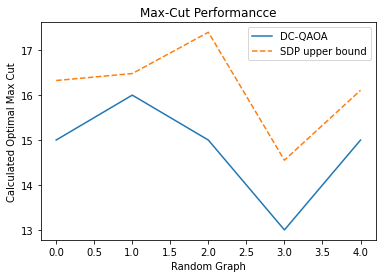

In [20]:
import matplotlib.pyplot as plt

plt.plot(value_dc_qaoa_ls, label="DC-QAOA")
plt.plot(ubound_sdp_ls, label="SDP upper bound", linestyle="--")
plt.title('Max-Cut Performancce')
plt.xlabel('Random Graph')
plt.ylabel('Calculated Optimal Max Cut')
plt.legend()
plt.show()

从上面的线形图中，我们可以说明``量子近似优化分治法``找到的最大割和理论上限接近。

## 应用

最大割问题属于应用范围很广的二次无约束二值优化（quadratic unconstrained binary optimization, QUBO）问题。此类问题的应用范围十分广泛，上至为NP-困难问题创建模型，下到找自旋玻璃的基态 [5]。同时最大割问题本身也有很广泛的应用。

最大割问题和很多领域都有紧密的联系，比如超大规模集成电路（VLSI circuit）设计，统计物理。减少超大规模集成电路设计所用的孔和寻找自选玻璃基态都可以归约到最大割问题 [6]。更重要的是，最大割问题给很多算法或者技术提供了一个测试台。比如适用于最大割问题的半正定规划方法被后续用在了数据集合设计 [7] 和相位检索上 [8, 9]。

更多关于最大割的应用可以在 [10-12] 里找到。

---

## 参考文献

[1] Akshay, V., et al. "Reachability deficits in quantum approximate optimization." [Physical Review Letters 124.9 (2020): 090504.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.124.090504)

[2] Li, Junde, Mahabubul Alam, and Swaroop Ghosh. "Large-scale Quantum Approximate Optimization via Divide-and-Conquer." [arXiv preprint arXiv:2102.13288 (2021).](https://arxiv.org/abs/2101.03717)

[3] Goemans, Michel X., and David P. Williamson. "Improved approximation algorithms for maximum cut and satisfiability problems using semidefinite programming." [Journal of the ACM (JACM) 42.6 (1995): 1115-1145.](http://www-math.mit.edu/~goemans/PAPERS/maxcut-jacm.pdf)

[4] Burer, Samuel, and Renato DC Monteiro. "Local minima and convergence in low-rank semidefinite programming." [Mathematical Programming 103.3 (2005): 427-444.](https://link.springer.com/article/10.1007/s10107-004-0564-1)

[5] Kochenberger, Gary, et al. "The unconstrained binary quadratic programming problem: a survey." [Journal of Combinatorial Optimization 28.1 (2014): 58-81.](https://link.springer.com/article/10.1007/s10878-014-9734-0)

[6] Barahona, Francisco, et al. "An application of combinatorial optimization to statistical physics and circuit layout design." [Operations Research 36.3 (1988): 493-513.](https://www.jstor.org/stable/170992?seq=1)

[7] Poland, Jan, and Thomas Zeugmann. "Clustering pairwise distances with missing data: Maximum cuts versus normalized cuts." [International Conference on Discovery Science. Springer, Berlin, Heidelberg, 2006.](https://link.springer.com/chapter/10.1007/11893318_21)

[8] Candes, Emmanuel J., et al. "Phase retrieval via matrix completion." [SIAM review 57.2 (2015): 225-251.](https://epubs.siam.org/doi/10.1137/110848074)

[9] Waldspurger, Irene, Alexandre d’Aspremont, and Stéphane Mallat. "Phase recovery, maxcut and complex semidefinite programming." [Mathematical Programming 149.1 (2015): 47-81.](https://link.springer.com/article/10.1007/s10107-013-0738-9)

[10] Deza, Michel, and Monique Laurent. "Applications of cut polyhedra—I." [Journal of Computational and Applied Mathematics 55.2 (1994): 191-216.](https://www.sciencedirect.com/science/article/pii/0377042794900205)

[11] Deza, Michel, and Monique Laurent. "Applications of cut polyhedra—II." [Journal of Computational and Applied Mathematics 55.2 (1994): 217-247.](https://www.sciencedirect.com/science/article/pii/0377042794900213)

[12] Poljak, Svatopluk, and Zsolt Tuza. "Maximum cuts and largest bipartite subgraphs." [DIMACS Series 20 (1995): 181-244.](https://arxiv.org/pdf/1810.12144.pdf)